Using device: cpu

0: 384x640 3 persons, 5 cars, 1 motorcycle, 1 bus, 1 bench, 162.5ms
Speed: 3.8ms preprocess, 162.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


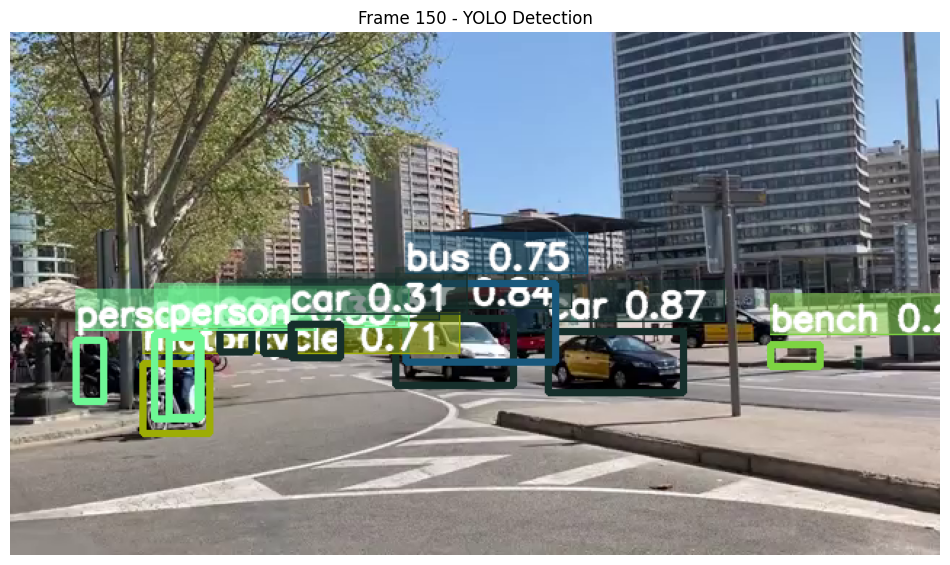

In [3]:
import cv2
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

model = YOLO("yolov8n.pt").to(device)

video_path = "/content/road_trafifc (1).mp4"
cap = cv2.VideoCapture(video_path)

# Specify the frame number to analyze
frame_number = 150
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

# Read the specific frame
ret, frame = cap.read()
if not ret:
    print(f"Failed to read frame {frame_number}.")
    cap.release()
    exit()

frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

results = model(frame_rgb)

# Generate random colors for each class
class_colors = {i: (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) for i in range(len(model.names))}

# Draw detections with enhanced visualization
for result in results:
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        confidence = box.conf[0]
        class_id = int(box.cls[0])
        label = model.names[class_id]
        color = class_colors[class_id]

        # Draw bounding box with thickness
        cv2.rectangle(frame_rgb, (x1, y1), (x2, y2), color, 4)

        (text_width, text_height), _ = cv2.getTextSize(f"{label} {confidence:.2f}", cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2)
        text_offset_x, text_offset_y = x1, y1 - 12
        text_bg_rect = frame_rgb[text_offset_y - text_height - 5:text_offset_y + 5, text_offset_x:text_offset_x + text_width + 10]

        # Applying transparency
        if text_bg_rect.shape[0] > 0 and text_bg_rect.shape[1] > 0:
            overlay = text_bg_rect.copy()
            cv2.rectangle(frame_rgb, (text_offset_x, text_offset_y - text_height - 5), (text_offset_x + text_width + 10, text_offset_y + 5), color, -1)
            cv2.addWeighted(overlay, 0.5, frame_rgb[text_offset_y - text_height - 5:text_offset_y + 5, text_offset_x:text_offset_x + text_width + 10], 0.5, 0, frame_rgb[text_offset_y - text_height - 5:text_offset_y + 5, text_offset_x:text_offset_x + text_width + 10])

        # Put text with better visibility
        cv2.putText(frame_rgb, f"{label} {confidence:.2f}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2, cv2.LINE_AA)

# Display the frame using Matplotlib
plt.figure(figsize=(12, 7))
plt.imshow(frame_rgb)
plt.axis("off")
plt.title(f"Frame {frame_number} - YOLO Detection")
plt.show()

cap.release()